In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.models import load_model

In [ ]:
INIT_LR = 1e-4
EPOCHS = 2
BS = 15
DIRECTORY = "dataset"

In [ ]:
data = []
labels = []

for category in os.listdir(DIRECTORY):
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)
print(labels[:10])

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
labels[:10]

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.20, stratify=labels, random_state=42)

In [1]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

NameError: name 'ImageDataGenerator' is not defined

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

In [25]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [26]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [27]:
for layer in baseModel.layers:
    layer.trainable = False

In [28]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


/Applications/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [29]:
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS), validation_data=(testX, testY), epochs=EPOCHS)

[INFO] training head...


2022-06-17 09:02:17.265599: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
300/300 [==============================] - 253s 827ms/step - loss: 0.2125 - accuracy: 0.9352 - val_loss: 0.0604 - val_accuracy: 0.9875
Epoch 2/2
300/300 [==============================] - 195s 650ms/step - loss: 0.0668 - accuracy: 0.9815 - val_loss: 0.0456 - val_accuracy: 0.9875


In [15]:
print(len(trainX))
print(len(testX))

4488
1123


In [16]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [17]:
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.98      0.99       497
without_mask       0.99      0.99      0.99       626

    accuracy                           0.99      1123
   macro avg       0.99      0.99      0.99      1123
weighted avg       0.99      0.99      0.99      1123



In [18]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format='h5')

[INFO] saving mask detector model...


/Applications/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


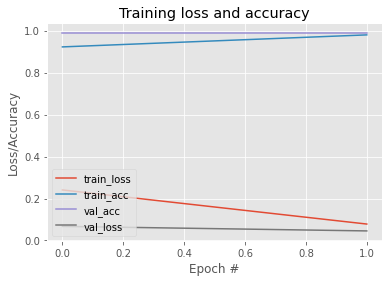

In [19]:
N = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.title("Training loss and accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
print(H.history)

In [35]:
#Testing with inputted image
data = []
labels = []
testImages = "inputtedImages"

for category in os.listdir(testImages):
    path = os.path.join(testImages, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

maskNet = load_model("mask_detector.model")
pred = maskNet.predict(data, batch_size=BS)


pred = np.argmax(pred, axis=1)

print(labels)
print(pred)

[[0. 1.]
 [1. 0.]]
[1 0]


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install imutils

In [ ]:
conda install -c conda-forge opencv